# Final Year Project: Detecting Scratch Noise in Vinyl Playback using Machine Learning
## By Sean Daly
## ID: 001013392-5
The aim of this final year project is to implement a Machine Learning Model that can detect noise in recordings of vinyl records.<br>
This notebook contains all the code for the project including analysis, implementation and testing and analysis of results.

In [1]:
#Importing Libraries
import os # used for file reading and handling
from os import listdir # lists files in the directory
import librosa # audio analysis library
import matplotlib.pyplot as plt # object-orientated graph plots
import librosa.display # used for displaying frequency graphs
import numpy as np # numpy, you should know what this is
import IPython.display as ipd # used for playing audio inside the notebook
import pandas as pd # used for storing data in neat tables
import sklearn
from joblib import dump, load # used for saving and loading model instances
from sklearn import svm

The data is stored in `_newDATA`, sampled at 22050Hz.

In [2]:
import sklearn

_newDATA = np.array(os.listdir("C:\\Users\\Sean Daly\\Desktop\\Final Year Project\\_newDATA"))
print(_newDATA.size)
print(_newDATA)
librosa.get_samplerate("C:\\Users\\Sean Daly\\Desktop\\Final Year Project\\_newDATA\\99P1999 sect0.wav")


3429
['01CR_RTH sect1.wav' '01DSOTM sect0.wav' '01GG sect1.wav' ...
 '99P1999 sect0.wav' '99Rev sect1.wav' '99SW sect0.wav']


22050

Here is an example of a snippet, with the structure of the data in the WAV file and the data represented as a spectrogram<br>
There is also an audio widget for you to listen to the file as well.

22050
-0.052093506
-0.05303955
-0.046524048
-0.036468506
-0.0362854
-0.029907227
-0.01838684
-0.008834839
-0.02722168
-0.039779663


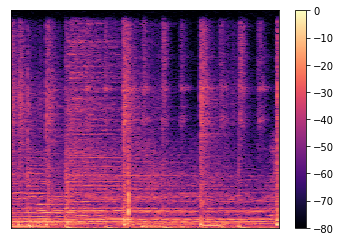

In [3]:
eg = "C:\\Users\\Sean Daly\\Desktop\\Final Year Project\\_newDATA\\101CR_RTH sect1.wav"
sr = librosa.get_samplerate(eg)
print(sr)
stream = librosa.stream(eg,
                      block_length = 2048,
                      frame_length = 2048,
                      hop_length = 2048)
i = 0
for y_block in stream:
    for block in range(1015,1025):
        print(y_block[block])
    D_block = librosa.stft(y_block, center=False)
    S_db = librosa.amplitude_to_db(np.abs(D_block), ref=np.max)
    plt.figure()
    librosa.display.specshow(S_db)
    plt.colorbar()

ipd.Audio(eg)

# Implementation Stage

## Preparing Data for experimental use
We need to remove half of the clean files to make the quantities equal, currently sitting at 2:1 clean to noisy.
We will be splitting the data into three subsets of 762 files, each with an even amount of noisy and clean files.

We then take `_data` and place the file names into a pandas `DataFrame` structure.

In [4]:
print("Snippets: " + str(len(_newDATA)))
data = {'File Name':  _newDATA}
df = pd.DataFrame (data, columns = ["File Name"])
df

Snippets: 3429


,File Name
0,01CR_RTH sect1.wav
1,01DSOTM sect0.wav
2,01GG sect1.wav
3,01P1999 sect1.wav
4,01Rev sect1.wav
...,...
3424,99DSOTM sect1.wav
3425,99GG sect1.wav
3426,99P1999 sect0.wav
3427,99Rev sect1.wav


We then create two new columns to hold the boolean values and file paths for each file. The flags signal if the file has noise included.<bl/>
This is achieved by creating two new DataFrames and then merging.

In [5]:
labels=[]
for file in _newDATA:
    l = file[len(file) -5]
    labels.append(l)
print(labels)
print(labels[10])
print(labels[11])
c = 0
for i in labels:
    if i == "0":
        labels[c] = "False"
    else:
        labels[c] = "True"
    c = c+1
temp = pd.DataFrame (labels, columns = ["isNoisy"])
_frame = pd.concat([df,temp], axis=1)

paths = []
for file in _newDATA:
    l = "C:\\Users\\Sean Daly\\Desktop\\Final Year Project\\_newDATA\\" + os.path.basename(file)
    paths.append(l)
print(paths)
temp = pd.DataFrame (paths, columns = ["filepath"])
frame = pd.concat([_frame,temp], axis=1)
frame

['1', '0', '1', '1', '1', '1', '1', '0', '1', '1', '1', '1', '1', '1', '1', '1', '0', '1', '1', '0', '1', '1', '1', '1', '1', '0', '1', '1', '1', '1', '1', '0', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '0', '1', '1', '1', '0', '1', '0', '1', '0', '0', '0', '1', '0', '1', '0', '0', '0', '1', '0', '1', '0', '0', '0', '0', '0', '1', '0', '1', '0', '0', '0', '1', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '1', '1', '0', '0', '0', '0', '0', '1', '1', '1', '1', '0', '0', '1', '1', '0', '1', '1', '1', '1', '0', '0', '0', '0', '0', '1', '1', '0', '1', '0', '0', '1', '1', '0', '1', '0', '0', '1', '1', '0', '0', '0', '0', '0', '1', '0', '0', '0', '1', '0', '1', '0', '0', '0', '0', '0', '1', '1', '0', '1', '0', '0', '0', '0', '0', '1', '0', '0', '0', '1', '0', '1', '0', '0', '0', '1', '0', '1', '0', '0', '0', '1', '0', '1', '0', '1', '0', '0', '0', '1', '0', '0', '0', '1', '0', '1', '0', '0', '0', '1', '1', '1', '1',

,File Name,isNoisy,filepath
0,01CR_RTH sect1.wav,True,C:\Users\Sean Daly\Desktop\Final Year Project\...
1,01DSOTM sect0.wav,False,C:\Users\Sean Daly\Desktop\Final Year Project\...
2,01GG sect1.wav,True,C:\Users\Sean Daly\Desktop\Final Year Project\...
3,01P1999 sect1.wav,True,C:\Users\Sean Daly\Desktop\Final Year Project\...
4,01Rev sect1.wav,True,C:\Users\Sean Daly\Desktop\Final Year Project\...
...,...,...,...
3424,99DSOTM sect1.wav,True,C:\Users\Sean Daly\Desktop\Final Year Project\...
3425,99GG sect1.wav,True,C:\Users\Sean Daly\Desktop\Final Year Project\...
3426,99P1999 sect0.wav,False,C:\Users\Sean Daly\Desktop\Final Year Project\...
3427,99Rev sect1.wav,True,C:\Users\Sean Daly\Desktop\Final Year Project\...


We then separate the noisy files from the clean ones, allowing us to balance the two subsets.

In [6]:
is_noisy = pd.DataFrame(frame.loc[frame['isNoisy'] == "True"])
not_noisy = pd.DataFrame(frame.loc[frame["isNoisy"] == "False"])
is_noisy.head()

,File Name,isNoisy,filepath
0,01CR_RTH sect1.wav,True,C:\Users\Sean Daly\Desktop\Final Year Project\...
2,01GG sect1.wav,True,C:\Users\Sean Daly\Desktop\Final Year Project\...
3,01P1999 sect1.wav,True,C:\Users\Sean Daly\Desktop\Final Year Project\...
4,01Rev sect1.wav,True,C:\Users\Sean Daly\Desktop\Final Year Project\...
5,01SW sect1.wav,True,C:\Users\Sean Daly\Desktop\Final Year Project\...


In [7]:
not_noisy.head()

,File Name,isNoisy,filepath
1,01DSOTM sect0.wav,False,C:\Users\Sean Daly\Desktop\Final Year Project\...
7,02DSOTM sect0.wav,False,C:\Users\Sean Daly\Desktop\Final Year Project\...
16,03Rev sect0.wav,False,C:\Users\Sean Daly\Desktop\Final Year Project\...
19,04DSOTM sect0.wav,False,C:\Users\Sean Daly\Desktop\Final Year Project\...
25,05DSOTM sect0.wav,False,C:\Users\Sean Daly\Desktop\Final Year Project\...


In [8]:
frame["isNoisy"].value_counts()

False    2286
True     1143
Name: isNoisy, dtype: int64

The not_noisy subset is the split in two, with one half being disposed of and the other being used.
Both non-noisy and noisy sets are divided by three and then get matched with an opposite third to create three mixed
subsets

In [9]:
not_noisy = not_noisy.iloc[::2] #splits the not_noisy subset in half

c1 = not_noisy.iloc[:381]
c2 = not_noisy.iloc[381:762]
c3 = not_noisy.iloc[762:]

d1 = is_noisy.iloc[:381]
d2 = is_noisy.iloc[381:762]
d3 = is_noisy.iloc[762:]

s1 = pd.concat([c1,d1], axis=0)
s2 = pd.concat([c2,d2], axis=0)
s3 = pd.concat([c3,d3], axis=0)

We then shuffle the rows of each of the subsets

In [10]:
rng = np.random.default_rng(0)
_s1 = s1.iloc[rng.permutation(len(s1))].reset_index(drop=True) #s1 will be used for deciding on kernel to use
_s2 = s2.iloc[rng.permutation(len(s2))].reset_index(drop=True) #s2 will be used for hyperparameter tuning
_s3 = s3.iloc[rng.permutation(len(s3))].reset_index(drop=True) #s3 will be used for an overall evaluation on the models performance
_s3

,File Name,isNoisy,filepath
0,459Rev sect1.wav,True,C:\Users\Sean Daly\Desktop\Final Year Project\...
1,473Rev sect0.wav,False,C:\Users\Sean Daly\Desktop\Final Year Project\...
2,80DSOTM sect1.wav,True,C:\Users\Sean Daly\Desktop\Final Year Project\...
3,458DSOTM sect0.wav,False,C:\Users\Sean Daly\Desktop\Final Year Project\...
4,674CR_RTH sect0.wav,False,C:\Users\Sean Daly\Desktop\Final Year Project\...
...,...,...,...
757,505SW sect1.wav,True,C:\Users\Sean Daly\Desktop\Final Year Project\...
758,459GG sect1.wav,True,C:\Users\Sean Daly\Desktop\Final Year Project\...
759,537CR_RTH sect0.wav,False,C:\Users\Sean Daly\Desktop\Final Year Project\...
760,443SW sect1.wav,True,C:\Users\Sean Daly\Desktop\Final Year Project\...


The predict method is used to predict frames in files as to if they are noisy or not. The method returns a scatterplot
showing detected noise in red as well as a count of the number of frames that are predicted noisy.

In [11]:
def predict(f, mod):
    model = mod
    sample = f
    test = librosa.stream(sample, block_length = 88200, frame_length = 1, hop_length = 1)
    val = []
    for line in test:
        for i in line:
            val.append([i])
    v = np.array(val)
    v.reshape(-1, 1)
    pred = model.predict(v)

    clean_count = 0
    noise_count = 0
    for flag in pred:
        if flag == -1:
            clean_count = clean_count + 1
        if flag == 1:
            noise_count = noise_count + 1
    print("Noisy frames : " + str(noise_count))
    print("Clean Frames : " + str(clean_count))
    pred.shape

    X = v
    Y = [range(0,X.size)]
    colors=['red' if x == 1 else 'blue' for x in pred]

    plt.scatter(Y,X, c = colors)

    stream = librosa.stream(sample,
                          block_length = 2048,
                          frame_length = 2048,
                          hop_length = 2048)
    for y_block in stream:
        D_block = librosa.stft(y_block, center=False)
        S_db = librosa.amplitude_to_db(np.abs(D_block), ref=np.max)
        plt.figure()
        librosa.display.specshow(S_db)
        plt.colorbar()

    ipd.Audio(f)


loading the training data and storing it under a variable:

In [12]:
train_data = "C:\\Users\\Sean Daly\\Desktop\\Final Year Project\\training data4.wav"
training_stream = librosa.stream(train_data, block_length = 176400, frame_length = 1, hop_length = 1)
tmp =[]
for l in training_stream:
    for i in l:
        tmp.append([i])
td = np.array(tmp)
td.reshape(-1, 1)
print(td)

[[0.16125488]
 [0.15434265]
 [0.18083191]
 ...
 [0.15646362]
 [0.11096191]
 [0.0632782 ]]


## Test 1: Training data optimisation, Kernel speed and performance
This test will use some files picked form the `_s1` test set.


It was found that the Linear Kernel was the fastest kernel to train and to predict with.
It performs strongly as well when compared with Sigmoid and Polynomial kernels. RBF failed to detect as many frames
as the others, however was able to detect noise that the other three missed.

Linear and RBF will be used in Test 2.

In [13]:
_s1

,File Name,isNoisy,filepath
0,168CR_RTH sect0.wav,False,C:\Users\Sean Daly\Desktop\Final Year Project\...
1,122CR_RTH sect1.wav,True,C:\Users\Sean Daly\Desktop\Final Year Project\...
2,152SW sect0.wav,False,C:\Users\Sean Daly\Desktop\Final Year Project\...
3,139P1999 sect0.wav,False,C:\Users\Sean Daly\Desktop\Final Year Project\...
4,107Rev sect0.wav,False,C:\Users\Sean Daly\Desktop\Final Year Project\...
...,...,...,...
757,110Rev sect0.wav,False,C:\Users\Sean Daly\Desktop\Final Year Project\...
758,101CR_RTH sect1.wav,True,C:\Users\Sean Daly\Desktop\Final Year Project\...
759,180DSOTM sect0.wav,False,C:\Users\Sean Daly\Desktop\Final Year Project\...
760,13DSOTM sect1.wav,True,C:\Users\Sean Daly\Desktop\Final Year Project\...


In [14]:
%%time

model_linear = sklearn.svm.OneClassSVM("linear")
model_rbf = sklearn.svm.OneClassSVM("rbf")
model_sigmoid = sklearn.svm.OneClassSVM("sigmoid")
model_poly = sklearn.svm.OneClassSVM("poly")

#model_linear.fit(td)
dump(model_linear, 'model_linear.joblib')

#model_rbf.fit(td)
dump(model_rbf, "model_rbf.joblib")

#model_sigmoid.fit(td)
dump(model_sigmoid, "model_sigmoid.joblib")

#model_poly.fit(td)
dump(model_poly, "model_poly.joblib")


model_linear = load("model_linear.joblib")
model_rbf = load("model_rbf.joblib")
model_sigmoid = load("model_sigmoid.joblib")
model_poly = load("model_poly.joblib")




Wall time: 27 ms


c:\users\sean daly\appdata\local\programs\python\python37\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass kernel=linear as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
c:\users\sean daly\appdata\local\programs\python\python37\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass kernel=rbf as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
c:\users\sean daly\appdata\local\programs\python\python37\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass kernel=sigmoid as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
c:\users\sean daly\appdata\local\programs\python\python37\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass kernel=poly as keyword args. From version 0.25 passing these as positional arguments will result in an err

In [15]:
%%time
#predict("C:\\Users\\Sean Daly\\Desktop\\Final Year Project\\_newDATA\\122CR_RTH sect1.wav", model_rbf)

Wall time: 0 ns


In [16]:
ipd.Audio("C:\\Users\\Sean Daly\\Desktop\\Final Year Project\\_newDATA\\101CR_RTH sect1.wav")


## Test 2: Hyperparameter Tuning
This next experiment is to fine tune the chosen kernel(s) with the SVM for optimal performance.
Like the previous experiment, the best performing kernel will be used in the final test.

In [17]:
model_rbf_scale = sklearn.svm.OneClassSVM("rbf", gamma="scale")
model_rbf_auto = sklearn.svm.OneClassSVM("rbf", gamma="auto")

In [18]:
#model_rbf_scale.fit(td)
dump(model_rbf_scale,"model_rbf_scale.joblib")

['model_rbf_scale.joblib']

In [19]:
#model_rbf_auto.fit(td)
dump(model_rbf_auto,"model_rbf_auto.joblib")

['model_rbf_auto.joblib']

In [20]:
model_rbf_1 = sklearn.svm.OneClassSVM("rbf", gamma= 0.001)
#model_rbf_1.fit(td)
dump(model_rbf_1, "model_rbf_1.joblib")

model_rbf_2 = sklearn.svm.OneClassSVM("rbf", gamma= 0.01)
#model_rbf_2.fit(td)
dump(model_rbf_2, "model_rbf_2.joblib")

model_rbf_3 = sklearn.svm.OneClassSVM("rbf", gamma= 0.1)
dump(model_rbf_3, "model_rbf_3.joblib")
#model_rbf_3.fit(td)
modle_linear = load("model_linear.joblib")

In [21]:
model_rbf_4 = sklearn.svm.OneClassSVM("rbf", nu= 0.345)
#model_rbf_4.fit(td)
dump(model_rbf_4, "model_rbf_4.joblib")

model_rbf_5 = sklearn.svm.OneClassSVM("rbf", nu= 0.3525)
#model_rbf_5.fit(td)
dump(model_rbf_5, "model_rbf_5.joblib")

model_rbf_6 = sklearn.svm.OneClassSVM("rbf", nu= 0.37)
dump(model_rbf_6, "model_rbf_6.joblib")
#model_rbf_6.fit(td)

['model_rbf_6.joblib']

In [22]:
#this section only needs to be ran if the models have been saved and can be loaded, othewise they need to be trained
#with the code cells above
model_rbf_1 = load("model_rbf_1.joblib")
model_rbf_2 = load("model_rbf_2.joblib")
model_rbf_3 = load("model_rbf_3.joblib")
model_rbf_4 = load("model_rbf_4.joblib")
model_rbf_5 = load("model_rbf_5.joblib")
model_rbf_6 = load("model_rbf_6.joblib")
_s2

,File Name,isNoisy,filepath
0,396SW sect1.wav,True,C:\Users\Sean Daly\Desktop\Final Year Project\...
1,324CR_RTH sect0.wav,False,C:\Users\Sean Daly\Desktop\Final Year Project\...
2,344Rev sect0.wav,False,C:\Users\Sean Daly\Desktop\Final Year Project\...
3,311GG sect1.wav,True,C:\Users\Sean Daly\Desktop\Final Year Project\...
4,33SW sect0.wav,False,C:\Users\Sean Daly\Desktop\Final Year Project\...
...,...,...,...
757,31CR_RTH sect1.wav,True,C:\Users\Sean Daly\Desktop\Final Year Project\...
758,281DSOTM sect0.wav,False,C:\Users\Sean Daly\Desktop\Final Year Project\...
759,273SW sect0.wav,False,C:\Users\Sean Daly\Desktop\Final Year Project\...
760,377CR_RTH sect0.wav,False,C:\Users\Sean Daly\Desktop\Final Year Project\...


In [23]:
model_rbf_x = sklearn.svm.OneClassSVM("rbf", nu = 0.345, gamma = 0.001)
#model_rbf_x.fit(td)

model_rbf_y = sklearn.svm.OneClassSVM("rbf", nu = 0.345, gamma = 0.01)
#model_rbf_y.fit(td)

model_rbf_z = sklearn.svm.OneClassSVM("rbf", nu = 0.345, gamma = 0.1)
#model_rbf_z.fit(td)

c:\users\sean daly\appdata\local\programs\python\python37\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass kernel=rbf as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [36]:
model_linear = sklearn.svm.OneClassSVM("linear", nu = 0.345)
model_linear.fit(td)

c:\users\sean daly\appdata\local\programs\python\python37\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass kernel=linear as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


OneClassSVM(kernel='linear', nu=0.345)

Noisy frames : 10
Clean Frames : 88190
Wall time: 13.2 s


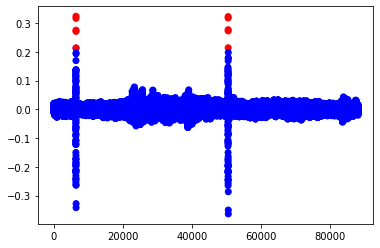

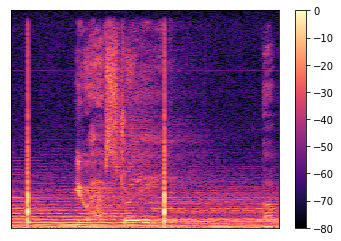

In [38]:
%%time
predict("C:\\Users\\Sean Daly\\Desktop\\Final Year Project\\_newDATA\\31CR_RTH sect1.wav", model_linear)


## Final Evaluation
This last part of the project will see the model predict all the files in s3 to evaluate its performance

In [26]:
_s3

,File Name,isNoisy,filepath
0,459Rev sect1.wav,True,C:\Users\Sean Daly\Desktop\Final Year Project\...
1,473Rev sect0.wav,False,C:\Users\Sean Daly\Desktop\Final Year Project\...
2,80DSOTM sect1.wav,True,C:\Users\Sean Daly\Desktop\Final Year Project\...
3,458DSOTM sect0.wav,False,C:\Users\Sean Daly\Desktop\Final Year Project\...
4,674CR_RTH sect0.wav,False,C:\Users\Sean Daly\Desktop\Final Year Project\...
...,...,...,...
757,505SW sect1.wav,True,C:\Users\Sean Daly\Desktop\Final Year Project\...
758,459GG sect1.wav,True,C:\Users\Sean Daly\Desktop\Final Year Project\...
759,537CR_RTH sect0.wav,False,C:\Users\Sean Daly\Desktop\Final Year Project\...
760,443SW sect1.wav,True,C:\Users\Sean Daly\Desktop\Final Year Project\...


### CAUTION: the cell below is commented out because it takes 3 HOURS to run, skip to the cell below to load the
### pre-determined labels

In [27]:
"""
model_linear = sklearn.svm.OneClassSVM("linear", nu = 0.345) # the model that passed test 2 from above
#model_linear.fit(td)

file_predictions = []

for ind in _s3.index:
    flag = False
    print(_s3.loc[ind,"filepath"])
    sample = _s3.loc[ind,"filepath"]
    test = librosa.stream(sample, block_length = 88200, frame_length = 1, hop_length = 1)
    val = []
    for line in test:
        for i in line:
            val.append([i])
    v = np.array(val)
    v.reshape(-1, 1)
    pred = model_linear.predict(v)
    for p in pred:
        if p == 1:
            flag = True
    file_predictions.append(flag)
    print(flag)

np.savetxt("file_predictions.txt", file_predictions)
"""

'\nmodel_linear = sklearn.svm.OneClassSVM("linear", nu = 0.345) # the model that passed test 2 from above\n#model_linear.fit(td)\n\nfile_predictions = []\n\nfor ind in _s3.index:\n    flag = False\n    print(_s3.loc[ind,"filepath"])\n    sample = _s3.loc[ind,"filepath"]\n    test = librosa.stream(sample, block_length = 88200, frame_length = 1, hop_length = 1)\n    val = []\n    for line in test:\n        for i in line:\n            val.append([i])\n    v = np.array(val)\n    v.reshape(-1, 1)\n    pred = model_linear.predict(v)\n    for p in pred:\n        if p == 1:\n            flag = True\n    file_predictions.append(flag)\n    print(flag)\n\nnp.savetxt("file_predictions.txt", file_predictions)\n'

In [28]:
file_predictions = np.loadtxt("file_predictions.txt")
fp = []
for i in range(file_predictions.size):
    if file_predictions[i] == 1.0:
        fp.append("True")
    else:
        fp.append("False")
print(range(file_predictions.size))

range(0, 762)


In [29]:
t = pd.DataFrame(fp, columns=["Predictions"])
Eval_Frame = pd.concat([_s3,t], axis=1)

In [30]:
Eval_Frame
Eval_Frame.to_csv("Eval_Frame.csv")

In [31]:
Eval_Frame

,File Name,isNoisy,filepath,Predictions
0,459Rev sect1.wav,True,C:\Users\Sean Daly\Desktop\Final Year Project\...,True
1,473Rev sect0.wav,False,C:\Users\Sean Daly\Desktop\Final Year Project\...,False
2,80DSOTM sect1.wav,True,C:\Users\Sean Daly\Desktop\Final Year Project\...,True
3,458DSOTM sect0.wav,False,C:\Users\Sean Daly\Desktop\Final Year Project\...,False
4,674CR_RTH sect0.wav,False,C:\Users\Sean Daly\Desktop\Final Year Project\...,False
...,...,...,...,...
757,505SW sect1.wav,True,C:\Users\Sean Daly\Desktop\Final Year Project\...,True
758,459GG sect1.wav,True,C:\Users\Sean Daly\Desktop\Final Year Project\...,True
759,537CR_RTH sect0.wav,False,C:\Users\Sean Daly\Desktop\Final Year Project\...,True
760,443SW sect1.wav,True,C:\Users\Sean Daly\Desktop\Final Year Project\...,True


Now with the Eval frame constructed, we can calculate some metrics to measure performance

In [32]:
TP = 0
TN = 0
FP = 0
FN = 0

for ind in Eval_Frame.index:
    if (Eval_Frame.loc[ind, "isNoisy"] == "True") and (Eval_Frame.loc[ind, "Predictions"] == "True"):
        TP = TP + 1
    elif (Eval_Frame.loc[ind, "isNoisy"] == "False") and (Eval_Frame.loc[ind, "Predictions"] == "False"):
        TN = TN + 1
    elif (Eval_Frame.loc[ind, "isNoisy"] == "True") and (Eval_Frame.loc[ind, "Predictions"] == "False"):
        FN = FN + 1
    elif (Eval_Frame.loc[ind, "isNoisy"] == "False") and (Eval_Frame.loc[ind, "Predictions"] == "True"):
        FP = FP + 1

In [33]:
print("True Positives: " + str(TP))
print("True Negatives: " + str(TN))
print("False Positives: " + str(FP))
print("False Negatives " + str(FN))

True Positives: 371
True Negatives: 297
False Positives: 84
False Negatives 10


In [34]:
precision = TP / (TP + FP)
recall = TP / (TP + FN)
accuracy = (TP + TN) / (TP + FP + TN + FN)
F1 = ((2 * precision * recall) / (precision + recall))

TPR = TP / (TP + FN)
FPR = FP / (FP + TN)

print("precision: " + str(precision))
print("recall: " + str(recall))
print("accuracy: " + str(accuracy))
print("F1: " + str(F1))
print("TPR: " + str(TPR))
print("FPR: " + str(FPR))



precision: 0.8153846153846154
recall: 0.973753280839895
accuracy: 0.8766404199475065
F1: 0.8875598086124402
TPR: 0.973753280839895
FPR: 0.2204724409448819
